In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import diffrax
import optax
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from tqdm import tqdm


from src.generator import reaction_diffusion_2d
from src.koopman import *
from src.nn import *
from src.utils import *

# Generate dynamics 
This time we use explicit coupling between reaction-diffusion equation.

$$
\frac{\partial u}{\partial t} = D_u \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) - u (u - a)(u - 1) + \beta v,
$$

$$
\frac{\partial v}{\partial t} = D_v \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right) - v (v - b)(v - 1) + \gamma u.
$$

With coupling terms, and the following conditions for causal direction: if $\beta = 0$, $u \rightarrow v$ ; else if $\gamma = 0$, $v \rightarrow u$.

__Here, we use $\gamma = 0$, with the causal direction $v \rightarrow u$.__

In [3]:
# Spatial domain
Lx, Ly = 1.0, 1.0
Nx, Ny = 16, 16
dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)
X, Y = jnp.meshgrid(
    jnp.linspace(0, Lx, Nx), 
    jnp.linspace(0, Ly, Ny), 
    indexing="ij"
)

# Time span
t0, t1 = 0.0, 10.0
dt = 0.001 

# Parameters
D_u, D_v = 0.1, 0.1  # Diffusion coefficients
a, b = 0.3, 0.3  # Reaction parameters

# Stability constraint for time step
max_dt = min(dx**2 / (2 * D_u), dy**2 / (2 * D_u))
dt = min(dt, max_dt)
steps = int((t1 - t0) / dt)

# Initial conditions
u_init = a + 0.1 * jnp.exp(-50 * ((X - 0.5) ** 2 + (Y - 0.5) ** 2))  # Near a
v_init = b + 0.1 * jnp.exp(-50 * ((X - 0.5) ** 2 + (Y - 0.5) ** 2))  # Near b
initial_state = jnp.concatenate([u_init.ravel(), v_init.ravel()])

# Coupling coefficients
beta, gamma = 10.0, 0.0  # gamma = 0 (v --> u), beta = 0 (u --> v)
args = (D_u, D_v, a, b, beta, gamma, Nx, Ny, dx, dy)


In [4]:
# Integration
solver = diffrax.Tsit5()  # Adaptive-step solver for stiff problems

solution = diffrax.diffeqsolve(
    diffrax.ODETerm(reaction_diffusion_2d),
    solver,
    t0=t0,
    t1=t1,
    dt0=dt,
    y0=initial_state,
    args=args,
    saveat=diffrax.SaveAt(ts=jnp.linspace(t0, t1, steps)),
    max_steps=100000
)

# Extract solutions for u and v
omega_1 = solution.ys[:, :Nx * Ny].T.reshape((Nx, Ny, -1)) # U
omega_2 = solution.ys[:, Nx * Ny:].T.reshape((Nx, Ny, -1)) # V


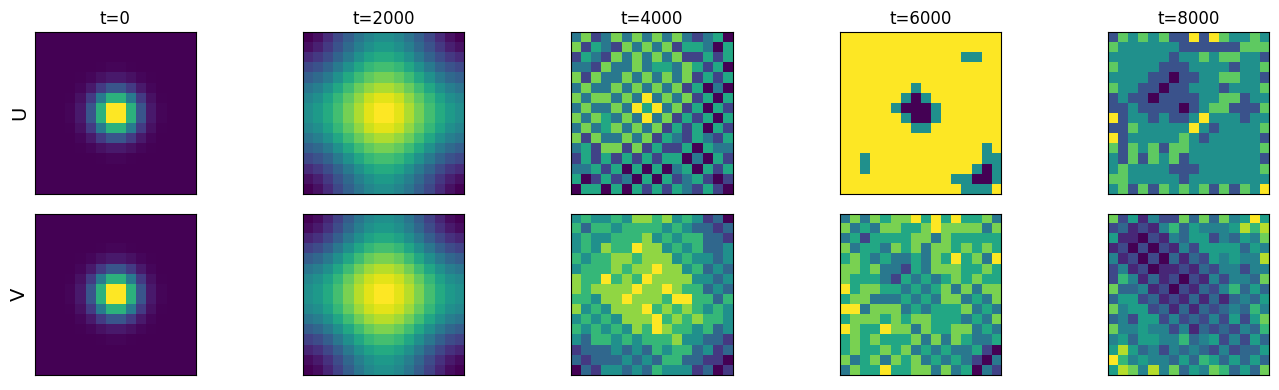

In [5]:
# Plot (without coupling)
n_plot = 5
n_skip = omega_1.shape[-1] // n_plot
f, ax = plt.subplots(2, n_plot, figsize=(14,4))

for i in range(n_plot):
    ax[0,i].imshow(omega_1[:, :, ::n_skip][:, :, i])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[0,i].set_title(f't={i*n_skip}')
    
    ax[1,i].imshow(omega_2[:, :, ::n_skip][:, :, i])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])

ax[0,0].set_ylabel('U', fontsize=14)
ax[1,0].set_ylabel('V', fontsize=14)
plt.tight_layout()
plt.show();


# Causal Koopman

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.19s/it]


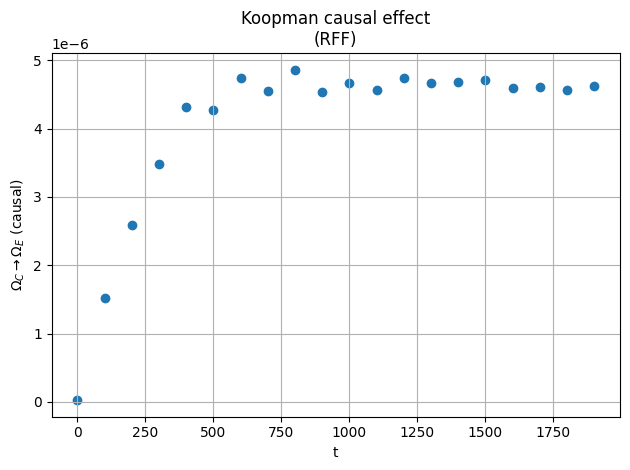

In [6]:
# Causal and non-causal direction (estimated by the causal loss)
flatten = lambda x: x.reshape(-1, x.shape[-1])
unflatten = lambda x: x.reshape(Nx, Ny, -1)

time_shifts = jnp.arange(1, 2000, 100)
losses = {'causal': [], 'non_causal': []}

for t in tqdm(time_shifts):

    # Causal
    causal_loss, _, _ = compute_causal_loss(
        cause=flatten(omega_2), 
        effect=flatten(omega_1),
        t=t
    )
    
    losses['causal'].append(causal_loss)

# Plot
plt.scatter(time_shifts, losses['causal'])
plt.xlabel('t')
plt.ylabel(r'$\Omega_C \rightarrow \Omega_E$ (causal)')

plt.title('Koopman causal effect\n(RFF)')
plt.grid()
plt.tight_layout()
plt.show();


### Conditioning forecasting

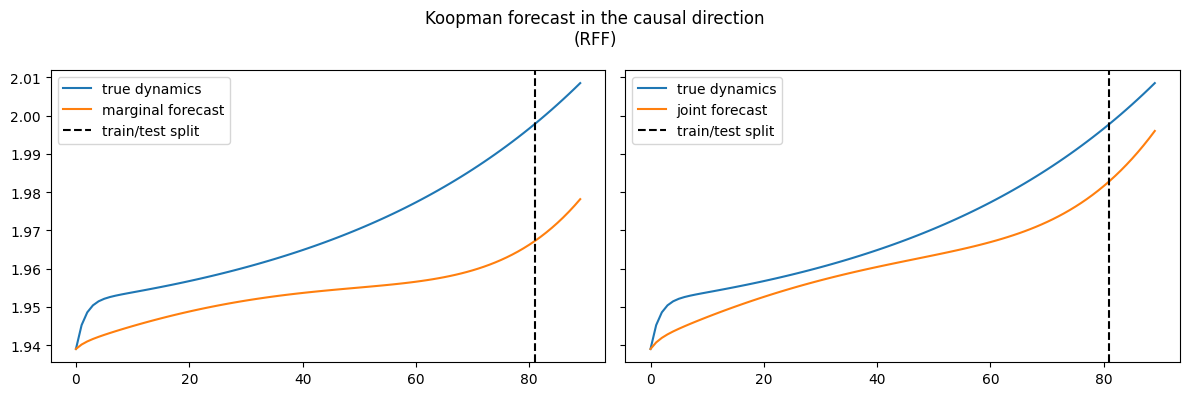

In [7]:
# Conditional inference (causal)
# Expected behavior: imperfect match in the marginal model, but better in the joint model.
start_idx, intervals = 1000, 100 # warmup, intervals
cause = omega_2[:, :, start_idx::intervals]
effect = omega_1[:, :, start_idx::intervals]
n_train = int(0.9 * effect.shape[-1])

omega_marginal, omega_joint = conditional_forecasting(
    cause = flatten(cause), 
    effect = flatten(effect), 
    n_train = n_train,
    t=1
)

omega_marginal = unflatten(omega_marginal)
omega_joint = unflatten(omega_joint)

# Plot (spatial average)
f, ax = plt.subplots(1, 2, figsize=(12,4), sharey=True)
ax[0].plot(flatten(effect).mean(axis=0), label='true dynamics')
ax[0].plot(flatten(omega_marginal).mean(axis=0), label='marginal forecast')
ax[0].axvline(n_train, color='black', linestyle='--', label='train/test split') 
ax[0].legend()

ax[1].plot(flatten(effect).mean(axis=0), label='true dynamics')
ax[1].plot(flatten(omega_joint).mean(axis=0), label='joint forecast')
ax[1].axvline(n_train, color='black', linestyle='--', label='train/test split') 
ax[1].legend()

f.suptitle('Koopman forecast in the causal direction\n(RFF)')
plt.tight_layout()
plt.show();


# Deep Causal Koopman

In [8]:
@jax.jit
def loss_fn(model, x, y):
    """Reconstruction loss."""
    y_pred = model.decoder(model.encoder(x))
    loss = jnp.mean(jnp.square(y_pred - y))
    return loss

@jax.jit
def train_step(model, opt_state, x, y):
    """Autograd routine."""
    loss, grads = jax.value_and_grad(loss_fn)(model, x, y)
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss


def train_model(model, x, y, n_train, epochs):
    """Utility function for training."""
    opt_state = optimizer.init(model)
    x, y = x[..., :n_train], y[..., :n_train]
    
    losses = []
    epoch_progress = tqdm(range(epochs))
    for epoch in epoch_progress:
        epoch_loss = 0.
        for t in range(x.shape[-1]):
            model, opt_state, loss = train_step(
                model, opt_state, 
                x = x[..., t], y = y[..., t]
            )

            epoch_loss += loss
        
        losses.append(epoch_loss / x.shape[-1])
        epoch_progress.set_description(f'Epoch: {epoch}; Loss: {loss:.4f}')

    return model, losses


Using neural network (encoder-decoder __MLP__) to approximate the lifting operators, i.e., y(t) = f[x(t)], where x(t) is the high-dimensional non-linear states, and y(t) is the functional.

In [9]:
# Hyperparameters
t = 1
train_f = 0.3
n_train = int(train_f * steps)
hidden_dims = [512, 1024]
epochs = 10
lr = 1e-4


In [10]:
# Construct dataset
cause = flatten(omega_2)
effect = flatten(omega_1)
effect_cause = jnp.concatenate([effect, cause], axis=0)

# z-normalize
cause_mean, cause_std = cause.mean(), cause.std()
effect_mean, effect_std = effect.mean(), effect.std()
effect_cause_mean, effect_cause_std = effect_cause.mean(), effect_cause.std()

cause = normalize(cause, cause_mean, cause_std)
effect = normalize(effect, effect_mean, effect_std)
effect_cause = normalize(effect_cause, effect_cause_mean, effect_cause_std)


Epoch: 9; Loss: 0.0000: 100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.59s/it]


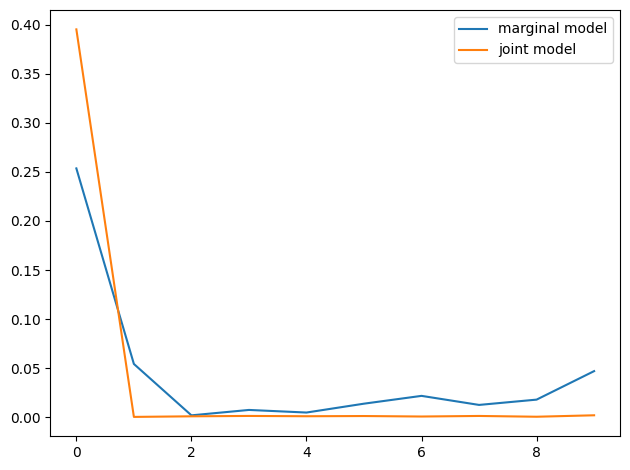

In [11]:
# Define model
optimizer = optax.adamw(learning_rate=lr)
marginal_model = NNTransformModel(input_dim=effect.shape[0], hidden_dims=hidden_dims, output_dim=effect.shape[0])
joint_model = NNTransformModel(input_dim=effect_cause.shape[0], hidden_dims=hidden_dims, output_dim=effect.shape[0])

# Fit models
marginal_model, marginal_loss = train_model(
    marginal_model, x=effect, y=effect, n_train=n_train, epochs=epochs
)

joint_model, joint_loss = train_model(
    joint_model, x=effect_cause, y=effect, n_train=n_train, epochs=epochs
)

# Plot loss
plt.plot(marginal_loss, label='marginal model')
plt.plot(joint_loss, label='joint model')

plt.legend()
plt.tight_layout()
plt.show();


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:42<00:00,  2.12s/it]


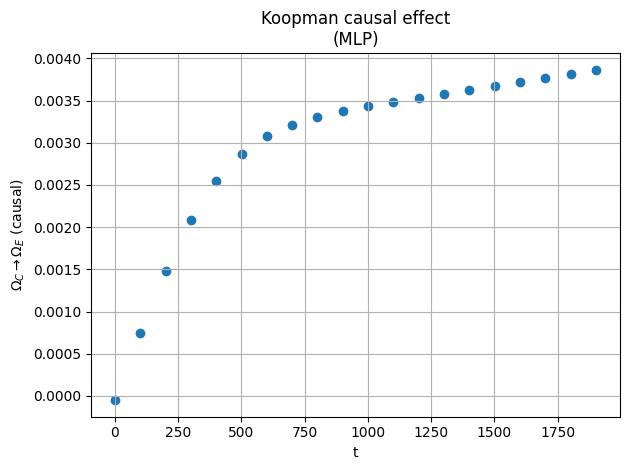

In [12]:
# Causal and non-causal direction (estimated by the causal loss)
time_shifts = jnp.arange(1, 2000, 100)
losses = {'causal': [], 'non_causal': []}

for t in tqdm(time_shifts):

    # Causal
    causal_loss, _, _ = compute_causal_loss(
        cause=flatten(omega_2), 
        effect=flatten(omega_1),
        t=t,
        marginal_model = marginal_model,
        joint_model = joint_model
    )
    
    losses['causal'].append(causal_loss)

# Plot
plt.scatter(time_shifts, losses['causal'])
plt.xlabel('t')
plt.ylabel(r'$\Omega_C \rightarrow \Omega_E$ (causal)')

plt.title('Koopman causal effect\n(MLP)')
plt.grid()
plt.tight_layout()
plt.show();


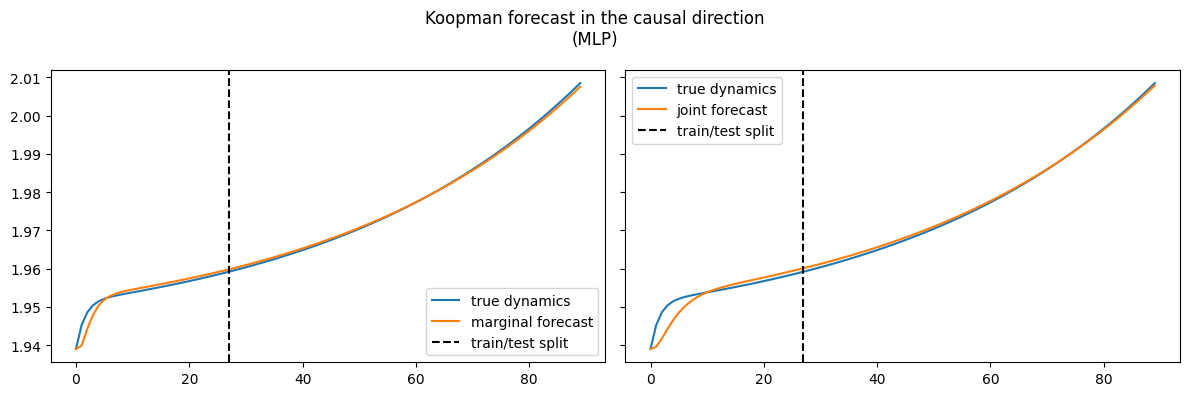

In [13]:
# Conditional inference (causal)
# Expected behavior: imperfect match in the marginal model, but better in the joint model.
start_idx, intervals = 1000, 100 # warmup, intervals
cause = omega_2[:, :, start_idx::intervals]
effect = omega_1[:, :, start_idx::intervals]

omega_marginal, omega_joint = conditional_forecasting(
    cause = flatten(cause), 
    effect = flatten(effect), 
    t=1,
    marginal_model = marginal_model,
    joint_model = joint_model
)

omega_marginal = unflatten(omega_marginal)
omega_joint = unflatten(omega_joint)

# Plot (spatial average)
f, ax = plt.subplots(1, 2, figsize=(12,4), sharey=True)
ax[0].plot(flatten(effect).mean(axis=0), label='true dynamics')
ax[0].plot(flatten(omega_marginal).mean(axis=0), label='marginal forecast')
ax[0].axvline(int(effect.shape[-1] * train_f), color='black', linestyle='--', label='train/test split') 
ax[0].legend()

ax[1].plot(flatten(effect).mean(axis=0), label='true dynamics')
ax[1].plot(flatten(omega_joint).mean(axis=0), label='joint forecast')
ax[1].axvline(int(effect.shape[-1] * train_f), color='black', linestyle='--', label='train/test split') 
ax[1].legend()

f.suptitle('Koopman forecast in the causal direction\n(MLP)')
plt.tight_layout()
plt.show();


Using neural network (encoder-decoder __CNN__) to approximate the lifting operators, i.e., y(t) = f[x(t)], where x(t) is the high-dimensional non-linear states, and y(t) is the functional.

In [14]:
# Hyperparameters
t = 1
n_train = int(0.3 * steps)
hidden_dims = [64, 128, 256, 512]
epochs = 10
lr = 1e-4


In [15]:
# Construct dataset
cause = omega_2[None, ...]
effect = omega_1[None, ...]
effect_cause = jnp.concatenate([effect, cause], axis=0)

# z-normalize
cause_mean, cause_std = cause.mean(), cause.std()
effect_mean, effect_std = effect.mean(), effect.std()
effect_cause_mean, effect_cause_std = effect_cause.mean(), effect_cause.std()

cause = normalize(cause, cause_mean, cause_std)
effect = normalize(effect, effect_mean, effect_std)
effect_cause = normalize(effect_cause, effect_cause_mean, effect_cause_std)


Epoch: 9; Loss: 0.0276: 100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [00:55<00:00,  5.59s/it]


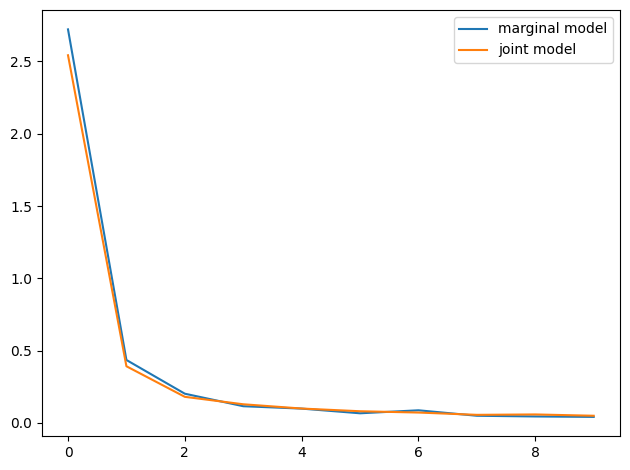

In [16]:
# Define model
optimizer = optax.adamw(learning_rate=lr)
marginal_model = CNNTransformModel(input_dim=effect.shape[0], hidden_dims=hidden_dims, output_dim=effect.shape[0])
joint_model = CNNTransformModel(input_dim=effect_cause.shape[0], hidden_dims=hidden_dims, output_dim=effect.shape[0])

# Fit models
marginal_model, marginal_loss = train_model(
    marginal_model, x=effect, y=effect, n_train=n_train, epochs=epochs
)

joint_model, joint_loss = train_model(
    joint_model, x=effect_cause, y=effect, n_train=n_train, epochs=epochs
)

# Plot loss
plt.plot(marginal_loss, label='marginal model')
plt.plot(joint_loss, label='joint model')

plt.legend()
plt.tight_layout()
plt.show();


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:59<00:00,  2.95s/it]


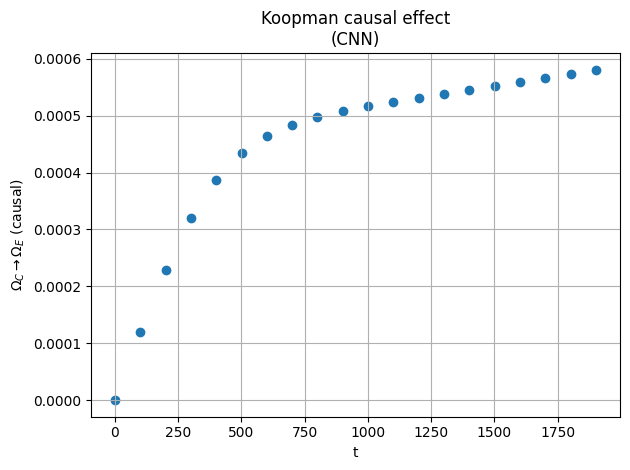

In [17]:
# Causal and non-causal direction (estimated by the causal loss)
time_shifts = jnp.arange(1, 2000, 100)
losses = {'causal': [], 'non_causal': []}

for t in tqdm(time_shifts):

    # Causal
    causal_loss, _, _ = compute_causal_loss(
        cause=omega_2[None, ...], 
        effect=omega_1[None, ...],
        t=t,
        marginal_model = marginal_model,
        joint_model = joint_model
    )

    # Non-causal
    non_causal_loss, _, _ = compute_causal_loss(
        cause=omega_1[None, ...], 
        effect=omega_2[None, ...],
        t=t,
        marginal_model = marginal_model,
        joint_model = joint_model
    )
    
    losses['causal'].append(causal_loss)
    losses['non_causal'].append(non_causal_loss)

# Plot
plt.scatter(time_shifts, losses['causal'])
plt.xlabel('t')
plt.ylabel(r'$\Omega_C \rightarrow \Omega_E$ (causal)')

plt.title('Koopman causal effect\n(CNN)')
plt.grid()
plt.tight_layout()
plt.show();

E1217 16:06:47.610802  740180 hlo_lexer.cc:443] Failed to parse int literal: 59765145324604646268936


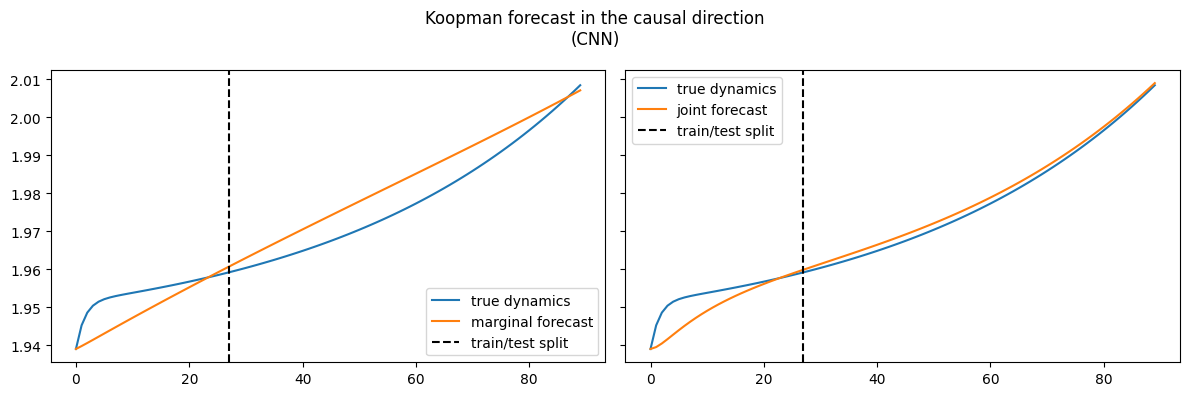

In [18]:
# Conditional inference (causal)
# Expected behavior: imperfect match in the marginal model, but better in the joint model.
start_idx, intervals = 1000, 100 # warmup, intervals
cause = omega_2[None,..., start_idx::intervals]
effect = omega_1[None,..., start_idx::intervals]

omega_marginal, omega_joint = conditional_forecasting(
    cause = cause, 
    effect = effect, 
    t = 1,
    marginal_model = marginal_model,
    joint_model = joint_model
)

omega_marginal = unflatten(omega_marginal)
omega_joint = unflatten(omega_joint)

# Plot (spatial average)
f, ax = plt.subplots(1, 2, figsize=(12,4), sharey=True)
ax[0].plot(flatten(effect).mean(axis=0), label='true dynamics')
ax[0].plot(flatten(omega_marginal).mean(axis=0), label='marginal forecast')
ax[0].axvline(int(effect.shape[-1] * train_f), color='black', linestyle='--', label='train/test split') 
ax[0].legend()

ax[1].plot(flatten(effect).mean(axis=0), label='true dynamics')
ax[1].plot(flatten(omega_joint).mean(axis=0), label='joint forecast')
ax[1].axvline(int(effect.shape[-1] * train_f), color='black', linestyle='--', label='train/test split') 
ax[1].legend()

f.suptitle('Koopman forecast in the causal direction\n(CNN)')
plt.tight_layout()
plt.show();
